In [1]:
# Load standard packages
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import numpy as np
import importlib
%matplotlib inline

# Load submodular package
import gm_submodular

In [2]:
# Load examples
import gm_submodular.example_objectives as ex

In [ ]:
#masukin data point di sini, ganti St.x dengan datapoint (bisa dummy, lebih baik ambil data entah dari mana)
dPoint = ([])

In [3]:
num_points=100
class St(gm_submodular.DataElement):
    budget=5
    #nanti si x diganti pake dPoint
    x=np.random.rand(num_points,2)
    dist_v=dist.pdist(x)
    Y=np.ones(num_points)
    def getCosts(self):
        return np.ones(num_points)
    def getDistances(self):
        d=dist.squareform(self.dist_v)
        return np.multiply(d,d)
S=St()


In [ ]:
#disini jalankan fungsi add/delete data
def emData():
    return 0
def remData(idx):
    dPoint.pop(idx)
    return dPoint


In [4]:
importlib.reload(ex)
importlib.reload(gm_submodular)
# Define the desired objectives
objectives=[ex.representativeness_shell(S), ex.random_shell(S)]
weights=[1,0]

# Maximize the objectives
selected_elements,score,minoux_bound=gm_submodular.leskovec_maximize(S,weights,objectives,budget=5)

Selected points: 8 53 62 41 69


Text(0.5,1,'greedy k-medoids solution')

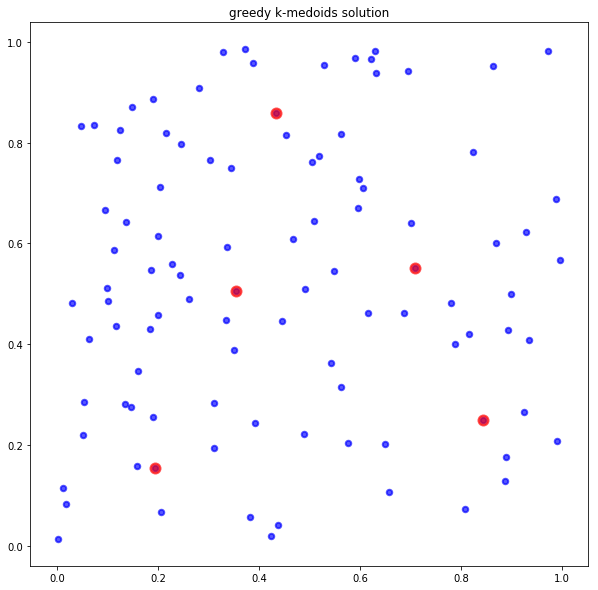

In [6]:
# Plot results
plt.figure(figsize=(10,10)) # Definition of a larger figure (in inches)
plt.scatter(S.x[:,0],S.x[:,1], c='blue', alpha=0.66, s=30, linewidths=2)
plt.scatter(S.x[selected_elements,0],S.x[selected_elements,1], c='red', s=100, alpha=0.66, linewidths=2)
print('Selected points: %s' % ' '.join(map(lambda x: str(x),selected_elements)))
plt.title('greedy k-medoids solution')

In [38]:
# Create tranining data (use result of the k-modoid objective)
training_examples=[]
importlib.reload(gm_submodular)
gm_submodular.logger.setLevel('DEBUG')
for i in range(0,50):
    S=St()
    S.budget=10
    S.clusters=np.array(np.random.rand(len(S.x))*5,np.int)
    selected_elements,score,_=gm_submodular.leskovec_maximize(S,weights,objectives,S.budget)
    S.y_gt=selected_elements
    training_examples.append(S)
    

In [39]:
# Learn the weights. Given that we used the k-medoid results as ground truth, this objective should get all the weight
shells=[ex.representativeness_shell,ex.random_shell,ex.random_shell,ex.random_shell,ex.random_shell]
loss=ex.intersect_complement_loss

# Use AdaGrad and a l-1 semiball projection (leads to sparser solutions, i.e. is more robust to noise)
#params=gm_submodular.SGDparams(use_l1_projection=True,max_iter=10,use_ada_grad=True)

#Alternatively, one could use vanilla SGD
params=gm_submodular.SGDparams()


In [40]:
#############
# LEARNING
# The weights are learnt using SGD (Note: This hardly converges, so define a reasonable number of maximal iterations)
# Also, given the stochasticity of the learning, you can expect some variance in the results.
####
learnt_weights,_=gm_submodular.learnSubmodularMixture(training_examples, shells,loss,params=params)





Break without convergence



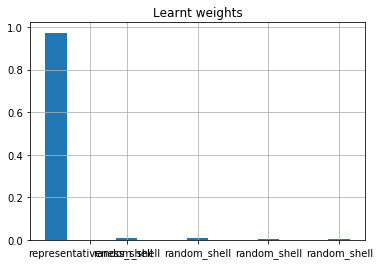

In [41]:
# Plot the learnt weights
width = 0.3
plt.bar(np.arange(0,len(learnt_weights)),learnt_weights,width)
plt.xticks(np.arange(0,len(learnt_weights))+learnt_weights/2., map(lambda x: x.__name__, shells))
plt.title('Learnt weights')
plt.grid()